In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#So there is no need for reloading notebook everytime you make changes in Helpfiles.py

import pandas as pd
import numpy as np
from Helpfiles import *
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline, Pipeline
## NAIVE BAYES
from sklearn.naive_bayes import CategoricalNB, BernoulliNB
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import interp
from itertools import cycle
import matplotlib.colors as mcolors
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, f1_score, average_precision_score, precision_recall_curve, plot_precision_recall_curve
import pickle
import matplotlib.colors as mcolors
from imblearn.over_sampling import SMOTE
plt.rcParams["figure.figsize"] = (12,8)



In [2]:
D = pd.read_csv('Myocardial infarction complications Database.csv', na_values ='?')
y = D["LET_IS"]
D = D.iloc[:, 0:D.shape[-1]-12]
D.drop("ID", axis=1, inplace=True)

X = D.copy()

#We remove initially columns with too many NA values.
RemoveColumns = ['NA_KB', 'LID_KB', 'NOT_NA_KB', 'S_AD_KBRIG', 'D_AD_KBRIG', 'IBS_NASL','KFK_BLOOD']
X = X.drop(columns = RemoveColumns)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123, stratify=y)



In [3]:
## Pipelines Creation
SI = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# LOAD FIT AND PREDICT (SIMPLE MODEL)

In [4]:
pipeline = Pipeline([
    #("ColumnRemover", RemoveNANsColumns()),
    #("NANremoverRow", RemoveNANsRows()), #SVDimputer går galt med denne 
    ("imputer", SVDImputer()),
    ("Scaling", None),
    ("classBalance", None),
    ("classifier", BernoulliNB())
])

In [5]:
with open("best_model_simple.pkl", "rb") as f:
    simple_params = pickle.load(f)
np.random.seed(42)
best_model_simple = pipeline.set_params(**simple_params)
best_model_simple.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('Scaling', None), ('classBalance', SMOTE()),
                ('classifier',
                 RandomForestClassifier(max_leaf_nodes=10, min_samples_leaf=15,
                                        n_estimators=1000))])

In [6]:
f1_score(best_model_simple.predict(X_test), y_test, average="macro")

0.22000025450473376

Predictions on test set: [0 0 0 3 0 0 6 6 1 0 0 0 0 0 0 0 0 0 0 7 0 0 3 0 0 0 0 0 0 0 0 0 3 0 6 0 0
 0 2 0 0 0 1 0 0 0 0 0 7 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 4 0 0 0 0 0 0 0 0 0 6 0 7
 0 2 0 0 0 0 0 1 0 0 0 2 0 0 3 0 6 0 0 0 0 3 0 7 0 1 0 0 0 0 0 0 6 0 0 4 0
 0 0 0 0 3 0 0 0 0 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 7 0 0 0 0 0 0 0 0 0 7 7 0 2 0 7 3 0 0 0 0 0 0 0 0 0 0 0 6 0 7 0 2 2
 0 0 0 0 0 2 3 0 0 0 0 0 6 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 7 1 0 0 6 0
 3 0 7 0 0 0 0 6 0 0 0 6 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 5 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0
 0 0 2 0 0 0 0]
True values on test set: [[0 0 0 0 0 0 0 4 7 0 0 0 0 3 5 0 0 0 0 1 0 0 3 0 3 0 3 0 0 0 0 0 7 1 0 0
  6 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 4 0 0 0 0 3 1 0 0 0 0 0 0 6 0 0 0 1 7 0 1 0 0 0 0 0 0 0
  0 0 1 0 1 0 0 0 0 0 6 0 1 0 1 0 3 0

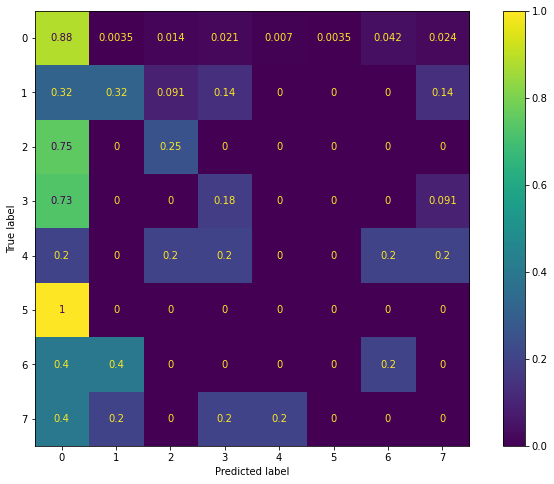

In [7]:
# Predictions
print('Predictions on test set:', best_model_simple.predict(X_test))
print('True values on test set:', np.array([y_test]))
plot_confusion_matrix(best_model_simple, X_test, y_test, normalize='true')

# LOAD FIT AND PREDICT (OVR MODEL)

In [8]:
pipeline = Pipeline([
    #("ColumnRemover", RemoveNANsColumns()),
    #("NANremoverRow", RemoveNANsRows()), #SVDimputer går galt med denne 
    ("imputer", SVDImputer()),
    ("Scaling", None),
    ("classBalance", None),
    ("classifier", BernoulliNB())
])

In [9]:
with open("best_model_ovr.pkl", "rb") as f:
    ovr_params = pickle.load(f)
np.random.seed(42)
best_model_ovr = pipeline.set_params(**ovr_params)
best_model_ovr.fit(X_train, y_train)

Pipeline(steps=[('imputer', SVDImputer()), ('Scaling', None),
                ('classBalance', SMOTE()),
                ('classifier',
                 OneVsRestClassifier(estimator=RandomForestClassifier(max_leaf_nodes=10,
                                                                      min_samples_leaf=15,
                                                                      n_estimators=1000)))])

In [10]:
f1_score(best_model_ovr.predict(X_test), y_test, average="macro")

0.1953781512605042

Predictions on test set: [0 0 0 3 0 0 0 6 1 0 0 0 0 0 0 0 0 0 0 7 0 0 3 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 7 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 7
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 7 0
 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0]
True values on test set: [[0 0 0 0 0 0 0 4 7 0 0 0 0 3 5 0 0 0 0 1 0 0 3 0 3 0 3 0 0 0 0 0 7 1 0 0
  6 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 4 0 0 0 0 3 1 0 0 0 0 0 0 6 0 0 0 1 7 0 1 0 0 0 0 0 0 0
  0 0 1 0 1 0 0 0 0 0 6 0 1 0 1 0 3 0

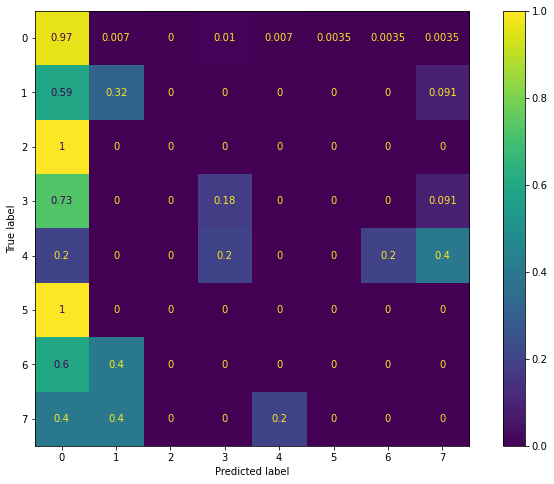

In [11]:
# Predictions
print('Predictions on test set:', best_model_ovr.predict(X_test))
print('True values on test set:', np.array([y_test]))
plot_confusion_matrix(best_model_ovr, X_test, y_test, normalize='true')

# FEATURE IMPORTANCES (SIMPLE MODEL)

Text(0.5, 1.0, 'Feature importances - Fraction of total importance: 0.57')

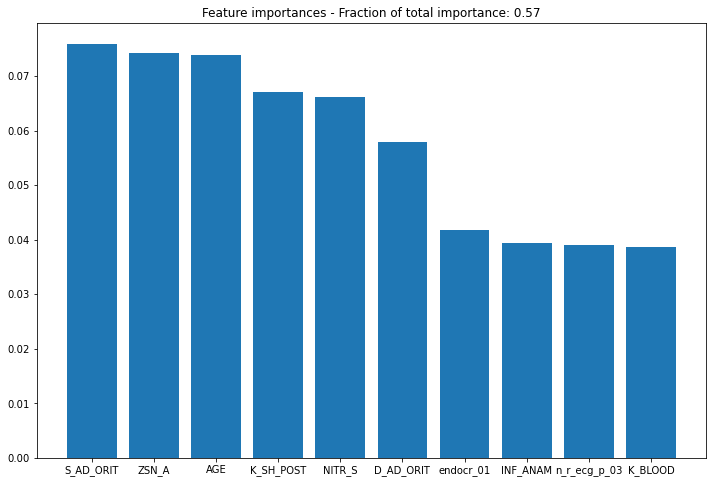

In [13]:
idx_highest = (-best_model_simple["classifier"].feature_importances_).argsort()[:10]
highest_importance_cols = list(X.columns[idx_highest])

fraction_importance = np.sum(best_model_simple["classifier"].feature_importances_[idx_highest]) / np.sum(best_model_simple["classifier"].feature_importances_)

plt.bar(highest_importance_cols, best_model_simple["classifier"].feature_importances_[idx_highest])
plt.title(f"Feature importances - Fraction of total importance: {round(fraction_importance, 2)}")

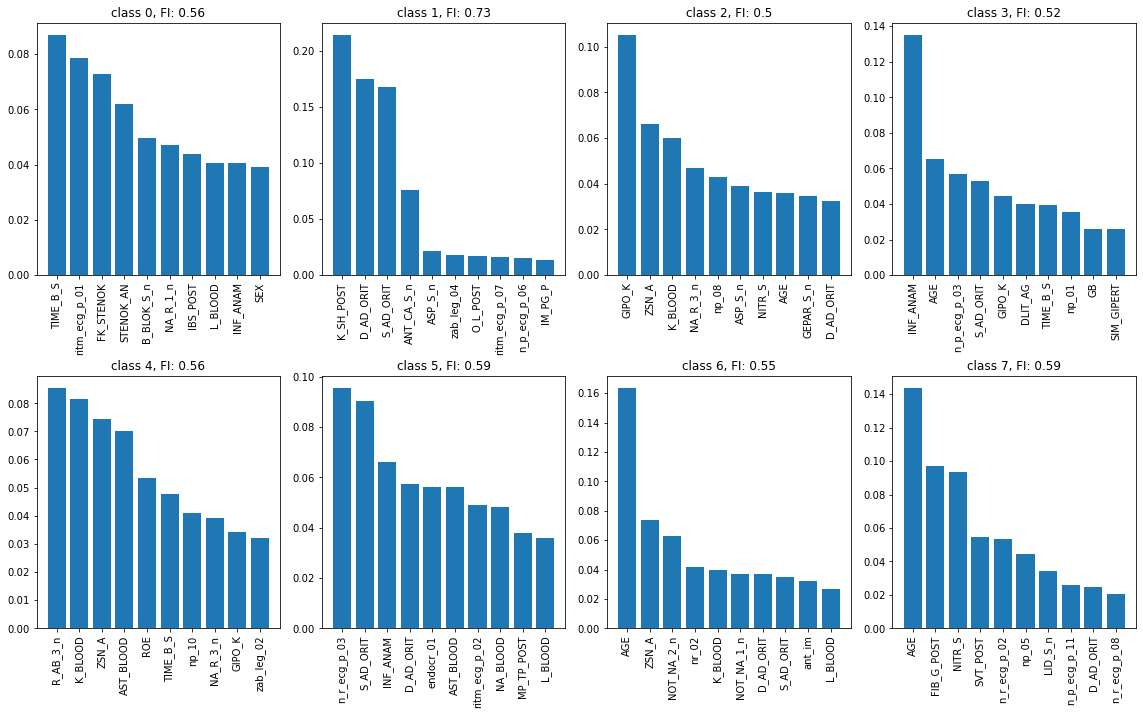

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
fig.tight_layout()
ax_flat = ax.flatten()
for i in range(n_classes):
    ax_i = ax_flat[i]
    
    idx_highest = (-best_model_ovr["classifier"].estimators_[i].feature_importances_).argsort()[:10]
    highest_importance_cols = list(X.columns[idx_highest])

    fraction_importance = np.sum(best_model_ovr["classifier"].estimators_[i].feature_importances_[idx_highest]) / np.sum(best_model_ovr["classifier"].estimators_[i].feature_importances_)

    ax_i.bar(highest_importance_cols, best_model_ovr["classifier"].estimators_[i].feature_importances_[idx_highest])
    ax_i.set_title(f"class {i}, FI: {round(fraction_importance, 2)}")
    ax_i.tick_params(axis='x', rotation=90)
fig.subplots_adjust(hspace=0.4)
plt.show()

# PRECISION CURVES (OVR MODEL)

In [14]:
y_score = best_model_ovr.predict_proba(X_test)
y_test_binarized = LabelBinarizer().fit_transform(y_test)
n_classes = y_test_binarized.shape[-1]

## MICRO

In [15]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.87


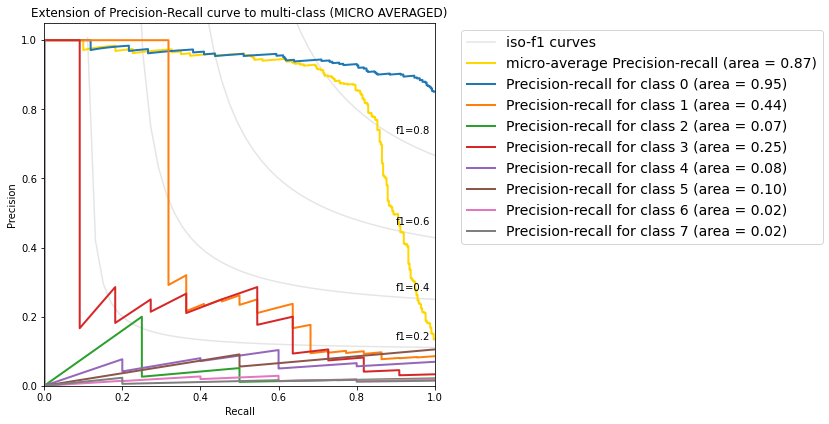

In [16]:
from itertools import cycle
# setup plot details
colors = cycle(mcolors.TABLEAU_COLORS)
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class (MICRO AVERAGED)')
plt.legend(lines, labels, prop=dict(size=14), bbox_to_anchor=(1.05, 1), loc='upper left')

## MACRO (CAN'T PLOT THE MACRO AVERAGE :/ )

In [17]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["macro"], recall["macro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_score.ravel())
average_precision["macro"] = average_precision_score(y_test_binarized, y_score,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.24


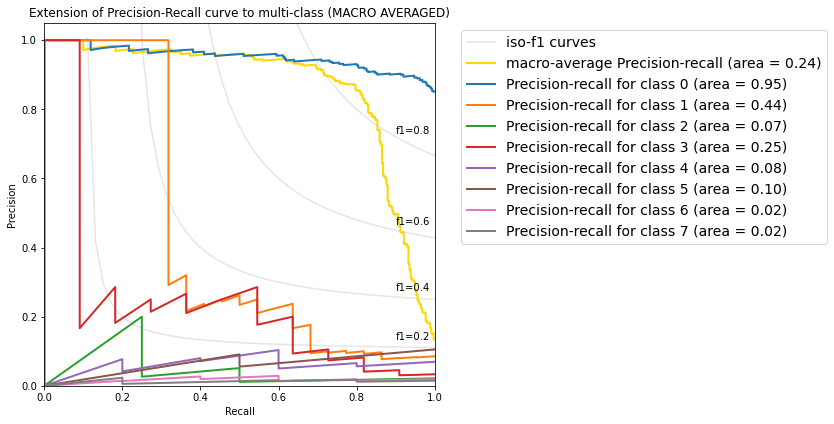

In [18]:
from itertools import cycle
# setup plot details
colors = cycle(mcolors.TABLEAU_COLORS)
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["macro"], precision["macro"], color='gold', lw=2)
lines.append(l)
labels.append('macro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["macro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class (MACRO AVERAGED)')
plt.legend(lines, labels, prop=dict(size=14), bbox_to_anchor=(1.05, 1), loc='upper left')